In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import log_loss, classification_report, accuracy_score, precision_recall_curve, auc, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning.
DATA_PATH = "/content/drive/MyDrive/Project_207/mids-207-summer-2025-keck/data/processed"

In [3]:
## Fetch the training, validation and test data.
X_train = pd.read_csv("/content/drive/MyDrive/Project_207/mids-207-summer-2025-keck/data/processed/hotel_bookings_X_train.csv")
X_val = pd.read_csv("/content/drive/MyDrive/Project_207/mids-207-summer-2025-keck/data/processed/hotel_bookings_X_val.csv")
X_test = pd.read_csv("/content/drive/MyDrive/Project_207/mids-207-summer-2025-keck/data/processed/hotel_bookings_X_test.csv")
Y_train = pd.read_csv("/content/drive/MyDrive/Project_207/mids-207-summer-2025-keck/data/processed/hotel_bookings_Y_train.csv")
Y_val = pd.read_csv("/content/drive/MyDrive/Project_207/mids-207-summer-2025-keck/data/processed/hotel_bookings_Y_val.csv")
Y_test = pd.read_csv("/content/drive/MyDrive/Project_207/mids-207-summer-2025-keck/data/processed/hotel_bookings_Y_test.csv")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of Y_train: {Y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of Y_val: {Y_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of Y_test: {Y_test.shape}")

Shape of X_train: (71632, 53)
Shape of Y_train: (71632, 1)
Shape of X_val: (23878, 53)
Shape of Y_val: (23878, 1)
Shape of X_test: (23878, 53)
Shape of Y_test: (23878, 1)


In [4]:
mlp = tf.keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.Dropout(0.1),

    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),

    layers.Dense(1, activation='sigmoid')
])

mlp.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),  # smaller LR for fine tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

mlp.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)


mlp_history = mlp.fit(
    X_train, Y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         6,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,177 (71.00 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 448 (1.75 KB)


Epoch 22: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.

Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 60: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 67: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 74: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.


In [5]:
# Get predicted probabilities
train_probs = mlp.predict(X_train).flatten()
val_probs = mlp.predict(X_val).flatten()
test_probs = mlp.predict(X_test).flatten()

# Convert probabilities to binary class labels
train_preds = (train_probs >= 0.57).astype(int)
val_preds = (val_probs >= 0.57).astype(int)
test_preds = (test_probs >= 0.57).astype(int)

# Accuracy scores
train_accuracy = accuracy_score(Y_train, train_preds)
val_accuracy = accuracy_score(Y_val, val_preds)
test_accuracy = accuracy_score(Y_test, test_preds)

# Log loss
train_log_loss = log_loss(Y_train, train_probs)
val_log_loss = log_loss(Y_val, val_probs)
test_log_loss = log_loss(Y_test, test_probs)

# Precision-Recall AUC
precision_train, recall_train, thresholds_train = precision_recall_curve(Y_train, train_probs)
pr_auc_train = auc(recall_train, precision_train)

precision_val, recall_val, thresholds_val = precision_recall_curve(Y_val, val_probs)
pr_auc_val = auc(recall_val, precision_val)

precision_test, recall_test, thresholds_test = precision_recall_curve(Y_test, test_probs)
pr_auc_test = auc(recall_test, precision_test)

# ROC AUC
fpr_train, tpr_train, thresholds_train = roc_curve(Y_train, train_probs)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_val, tpr_val, thresholds_val = roc_curve(Y_val, val_probs)
roc_auc_val = auc(fpr_val, tpr_val)

fpr_test, tpr_test, thresholds_test = roc_curve(Y_test, test_probs)
roc_auc_train = auc(fpr_test, tpr_test)

2239/2239 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
747/747 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
747/747 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


=> Training Set Results: 
Training Accuracy: 0.83
Training Log Loss: 0.36
Classification Report:

               precision    recall  f1-score   support

           0       0.81      0.95      0.87     45099
           1       0.88      0.62      0.73     26533

    accuracy                           0.83     71632
   macro avg       0.84      0.79      0.80     71632
weighted avg       0.84      0.83      0.82     71632

PR AUC Curve:




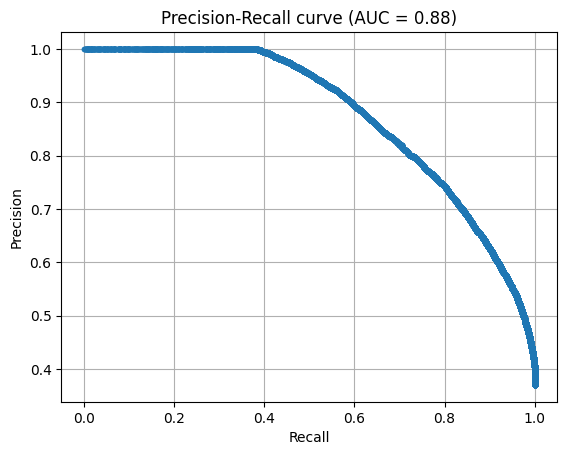

ROC AUC Curve:




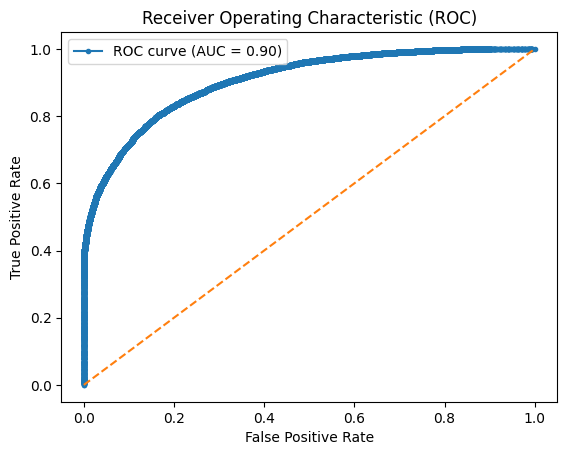

---------------------------------------------------------------------------
=> Validation Set Results: 
Validation Accuracy: 0.83
Validation Log Loss: 0.36
Classification Report:

               precision    recall  f1-score   support

           0       0.81      0.95      0.87     15033
           1       0.87      0.63      0.73      8845

    accuracy                           0.83     23878
   macro avg       0.84      0.79      0.80     23878
weighted avg       0.83      0.83      0.82     23878

PR AUC Curve:




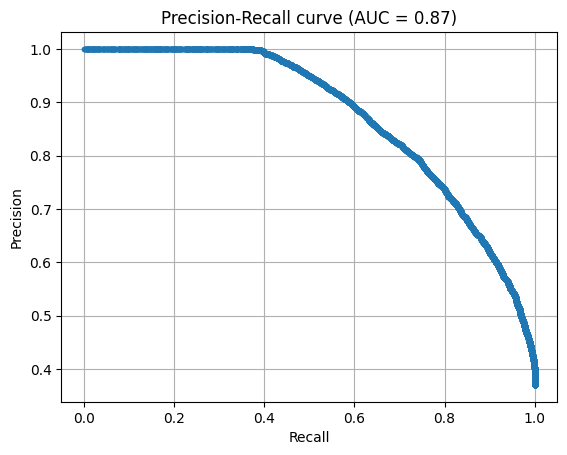

ROC AUC Curve:




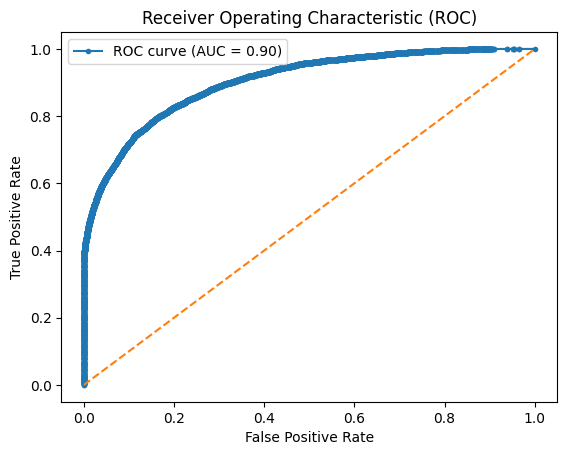

---------------------------------------------------------------------------
=> Test Set Results: 
Test Accuracy: 0.82
Test Log Loss: 0.37
Classification Report:

               precision    recall  f1-score   support

           0       0.80      0.95      0.87     15033
           1       0.87      0.60      0.71      8845

    accuracy                           0.82     23878
   macro avg       0.84      0.78      0.79     23878
weighted avg       0.83      0.82      0.81     23878

PR AUC Curve:




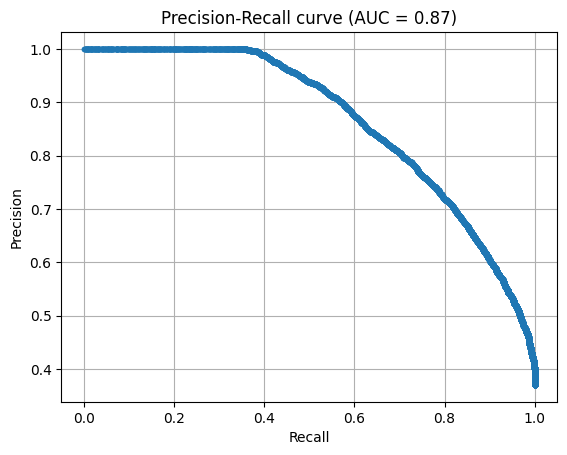

ROC AUC Curve:




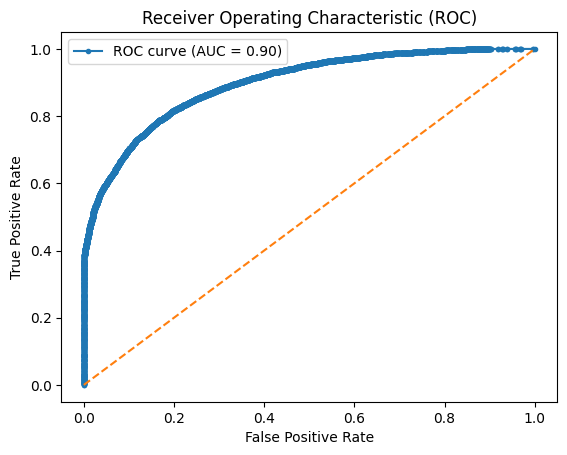

In [6]:
print("=> Training Set Results: ")
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Training Log Loss: {train_log_loss:.2f}")
print(f"Classification Report:\n\n", classification_report(Y_train, train_preds))
print("PR AUC Curve:\n\n")
plt.plot(recall_train, precision_train, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AUC = {pr_auc_train:.2f})')
plt.grid(True)
plt.show()
print("ROC AUC Curve:\n\n")
plt.plot(fpr_train, tpr_train, marker='.', label=f'ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.show()
print("-"*75)

print("=> Validation Set Results: ")
print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Validation Log Loss: {val_log_loss:.2f}")
print(f"Classification Report:\n\n", classification_report(Y_val, val_preds))
print("PR AUC Curve:\n\n")
plt.plot(recall_val, precision_val, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AUC = {pr_auc_val:.2f})')
plt.grid(True)
plt.show()
print("ROC AUC Curve:\n\n")
plt.plot(fpr_val, tpr_val, marker='.', label=f'ROC curve (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.show()
print("-"*75)

print("=> Test Set Results: ")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Log Loss: {test_log_loss:.2}")
print(f"Classification Report:\n\n", classification_report(Y_test, test_preds))
print("PR AUC Curve:\n\n")
plt.plot(recall_test, precision_test, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AUC = {pr_auc_test:.2f})')
plt.grid(True)
plt.show()
print("ROC AUC Curve:\n\n")
plt.plot(fpr_test, tpr_test, marker='.', label=f'ROC curve (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.show()